In [41]:
import numpy as np, cv2, os
from matplotlib import pyplot as plt
import tensorly as tl
from misc_tools.print_latex import print_tex

Singular value decomposition: compression

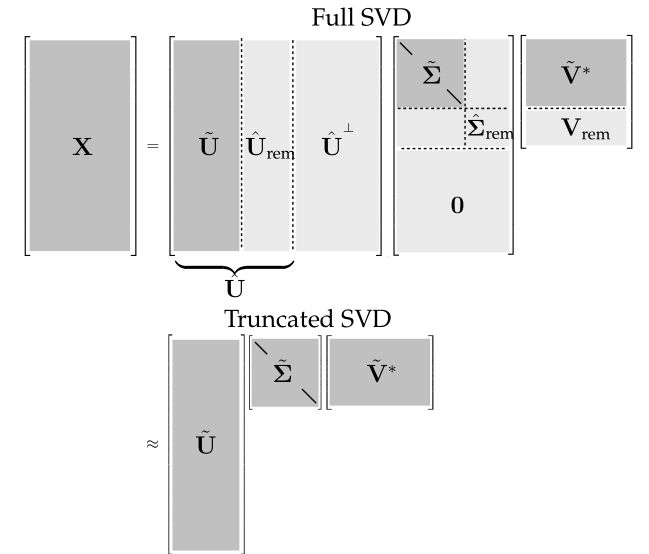

SVD is similar to eigenproblem with sigma containing eigenvalues, which are ordered by weight

full matrix SVD contains zero rows/cols, which dont contribute anything. they can be cut out or SVD can be generated without them

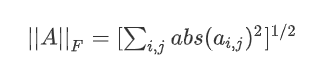

difference between OG matrix and its decomposition can be calculated using Frobenius norm: $np.linalg.norm(matrix, ord = 'fro')$

In [42]:
X = np.random.rand(5,2)

U,S,V = np.linalg.svd(X,full_matrices=True) # S is list of diag elements, not a matrix
print('USV shapes    ', U.shape, np.diag(S).shape, V.shape)

U_hat,S_hat,V_hat = np.linalg.svd(X,full_matrices=False)
print('USV_hat shapes',U_hat.shape, np.diag(S_hat).shape, V_hat.shape)

X_reconstructed = U_hat@np.diag(S_hat) @ V_hat.T
dif_norm = np.linalg.norm(X- X_reconstructed, ord = 'fro')
print(dif_norm)

USV shapes     (5, 5) (2, 2) (2, 2)
USV_hat shapes (5, 2) (2, 2) (2, 2)
2.178596206055444


sigma values and rows of U,V are ordered inhierarchy. first elements have higher contribution to matrix.

by trunkating USV matrices we obtain objects with less information = compressed. where to perform a cutoff?

(2000, 2000) (1500,) (1500, 1500)
OG shape: (2000, 1500) and total # of elements =  3000000
r =  5 ; shapes: (2000, 5) (5, 5) (5, 1500) = 17525 elements in total
r =  20 ; shapes: (2000, 20) (20, 20) (20, 1500) = 70400 elements in total
r =  100 ; shapes: (2000, 100) (100, 100) (100, 1500) = 360000 elements in total


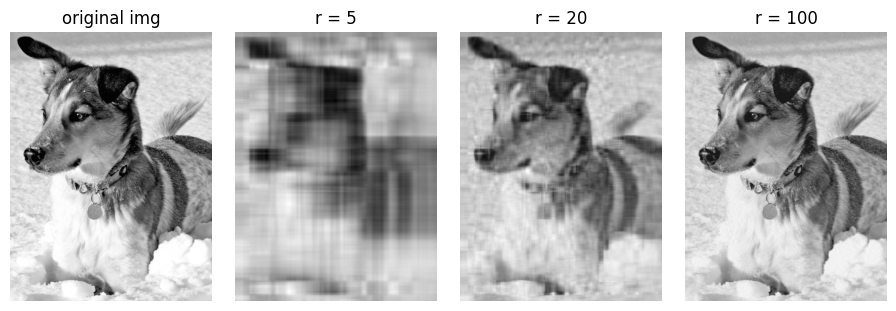

In [43]:
img = np.array(cv2.imread(os.path.join('data_processing','media','dog.jpg'), 0), float)
U,S,V = np.linalg.svd(img,full_matrices=True)
print(U.shape, S.shape, V.shape)
fig, ax = plt.subplots(1,4, layout='constrained',figsize = (9,3))
ax = ax.reshape(ax.size)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original img', fontsize=12)
ax[0].axis('off')
print('OG shape:', img.shape, 'and total # of elements = ', img.size)
for i,r in enumerate([5, 20, 100]):
    U_trunk = U[:,:r] 
    S_trunk = np.diag(S[:r])
    V_trunk = V[:r,:]
    total_size = U_trunk.size + S_trunk.size + V_trunk.size
    print('r = ', r, '; shapes:', U_trunk.shape, S_trunk.shape, V_trunk.shape, '=', total_size, 'elements in total')
    approx = U_trunk @ S_trunk @ V_trunk
    ax[i + 1].imshow(approx, cmap='gray')
    ax[i + 1].set_title(f'r = {r}', fontsize=12)
    ax[i + 1].axis('off')
    

Text(0.5, 0, 'r')

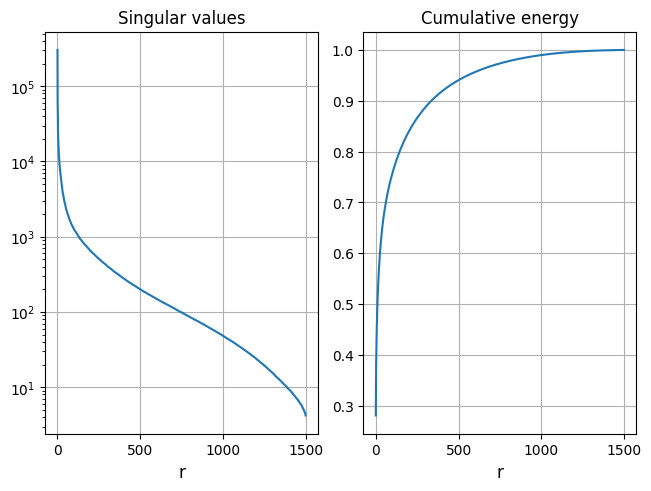

In [44]:
fig, ax2 = plt.subplots(1,2, layout='constrained', sharex=True)
ax2[0].semilogy(S)
ax2[0].set_title('Singular values', fontsize=12)
ax2[0].set_xlabel('r', fontsize=12)
ax2[1].plot(np.cumsum(S)/np.sum(S))
ax2[1].set_title('Cumulative energy', fontsize=12)
ax2[1].set_xlabel('r', fontsize=12)

Singular value decomposition: 1d regression

Because U and V are unitary, they are easily invertible by transposing. Diagonal matrix inversion is even simpler 1/M

We can solve A*x = b easy with this SVD.

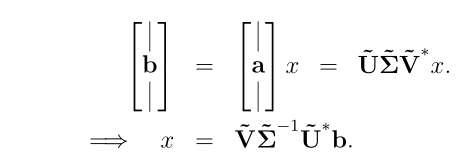

In fact A can be non-square, and you can solve overdetermined as well as underdetermined problems (closest fit)

(16, 1) (1,) (1, 1)


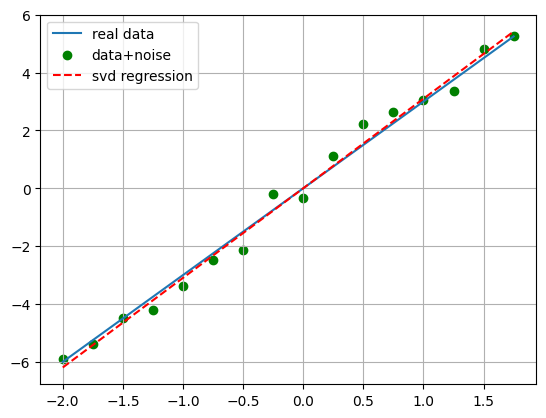

In [45]:
slope = 3
param_a = np.arange(-2.0, 2.0, 0.25)                # domain
param_a = param_a.reshape(-1,1)                     # form a matrix (N,1)
noise = (np.random.rand(*param_a.shape)-0.5)*1.5    # generate noise
param_b = slope*param_a + noise                     # gen linearly related data

U_hat,S_hat,V_hat = np.linalg.svd(param_a,full_matrices=False)
print(U_hat.shape, S_hat.shape, V_hat.shape)
S_hat_inv = (1/np.diag(S_hat))
left_side = V_hat @ S_hat_inv @ U_hat.T
x_prim =  left_side @ param_b

plt.plot(param_a,slope*param_a, label='real data')
plt.scatter(param_a,param_b, c='g',label='data+noise')
plt.plot(param_a,x_prim * param_a, c='r', linestyle='--', label='svd regression')
plt.legend()

Principle Component Analysis (PCA)

[[2. 2. 2.]
 [1. 1. 1.]]
[[ 0.28353452  1.38418997 -0.72632076]
 [-0.13828952  0.98108507 -0.11120633]]


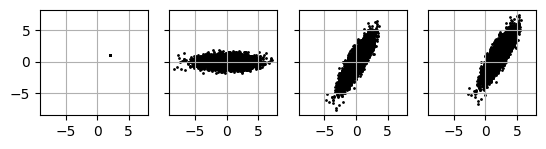

In [46]:
plt.rcParams['axes.grid'] = True
center = np.array([2,1])
scaling = np.array([2,0.5])

theta = np.pi/3
M_rot = np.array([
                    [np.cos(theta),    -np.sin(theta)],
                    [np.sin(theta),     np.cos(theta)]
                ])

num_points = 10000
n_centers = np.diag(center) @ np.ones((2,num_points))                   ; print(n_centers[:,:3])
n_gaussians = np.diag(scaling) @ np.random.normal(size=(2, num_points))  ; print(n_gaussians[:,:3])
n_gauss_rot = M_rot @ n_gaussians
X = n_gauss_rot + n_centers
fig, ax = plt.subplots(1,4, sharex=True, sharey=True)
#ax = ax.reshape(ax.size)
for i, pts in enumerate([n_centers, n_gaussians, n_gauss_rot, X]):
    ax[i].scatter(pts[0,:]    , pts[1,:], s = 1, c = 'k')
    ax[i].set_aspect(1)


Can do SVD on data. have to translate to percieved center.

U-matrix matches rotation matrix M_rot and S values match scaling of gaussian axis

USV shapes:
 (2, 2) (2,) (2, 10000)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

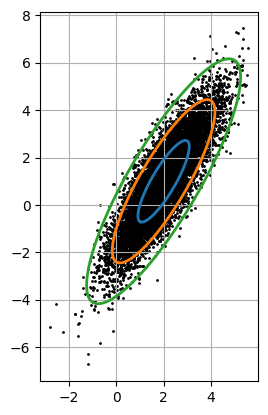

In [47]:
X_avg = np.mean(X,axis=1)
X_offsets = np.diag(X_avg) @ np.ones((2,num_points))     

B = X - X_offsets

U,S,V = np.linalg.svd(B/np.sqrt(num_points), full_matrices=False)
print(f'USV shapes:\n',U.shape, S.shape, V.shape)

print_tex('offsets:', X_offsets[:,:3])
print_tex(r'M_{rot}=',M_rot,',U=',U)
print_tex('STDEVS=',scaling, ', S_{elements}=',S)


# draw bands by deforming points forming a circle using S value scales
thetas = 2*np.pi * np.arange(0,1,0.01)
ellipse = np.diag(S) @ np.array([np.cos(thetas), np.sin(thetas)])
# rotate by U, offset to X_avg during plot
X_std = U @ ellipse

fig, ax2 = plt.subplots(1,1, sharex=True, sharey=True)
ax2.scatter(X[0,:]    , X[1,:], s = 1, c= 'k')
for k in [1,2,3]:
    ax2.plot(X_avg[0] + k* X_std[0,:]   , X_avg[1] + k* X_std[1,:], lw= 2)
ax2.set_aspect(1)

truncating. generate problem with known rank (rank = 2). we can then apply theory for cases where noise level is known

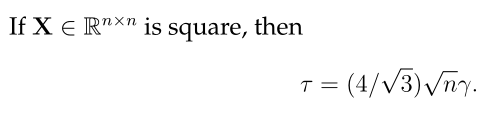

energy at entries r and r + 1 0.899555225027596 0.9005703773056934


Text(0.5, 1.0, 'trunkated SVD by 90% energy')

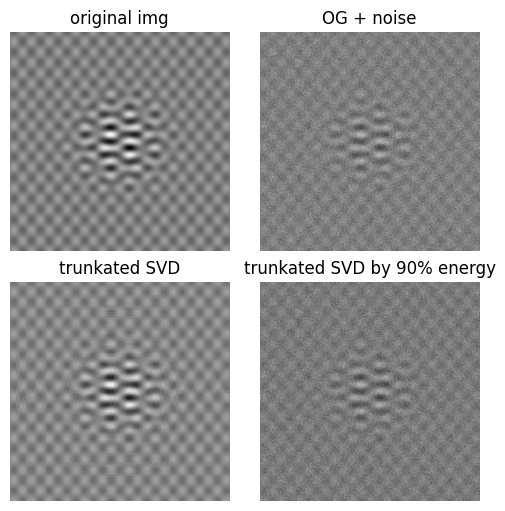

In [48]:
t = np.arange(-3,3,0.01)
Utrue = np.array([
                    np.cos(17*t)*np.exp(-t**2), 
                    np.sin(11*t)
                ])

Strue = np.diag([2, 0.5])

Vtrue = np.array([
                    np.sin(5*t)*np.exp(-t**2),
                    np.cos(13*t)
                ])

X = Utrue.T @ Strue @ Vtrue

fig, ax = plt.subplots(2,2, layout='constrained', figsize = (5,5))
ax = ax.reshape(ax.size)
ax[0].imshow(X, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('original img', fontsize=12)

gamma = 1;
noise = gamma*np.random.randn(*X.shape)
X_noise = X + noise

ax[1].imshow(X_noise, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('OG + noise', fontsize=12)

cutoff = (4/np.sqrt(3)) * np.sqrt(t.size) * gamma

U,S,V = np.linalg.svd(X_noise, full_matrices=False)

r = np.max(np.where(S>cutoff)) + 1  # counting form zero
X_trunk = U[:,:r] @ np.diag(S[:r]) @ V[:r,:]

ax[2].imshow(X_trunk, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('trunkated SVD', fontsize=12)

#cumulative energy
en = np.cumsum(S)/np.sum(S)
r2 = np.max(np.where(en < 0.9))
print('energy at entries r and r + 1',en[r2], en[r2 + 1])
X_90en = U[:,:r2] @ np.diag(S[:r2]) @ V[:r2,:]

ax[3].imshow(X_90en, cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('trunkated SVD by 90% energy', fontsize=12)

Text(0.5, 1.0, 'total energy and and trankation thresholds')

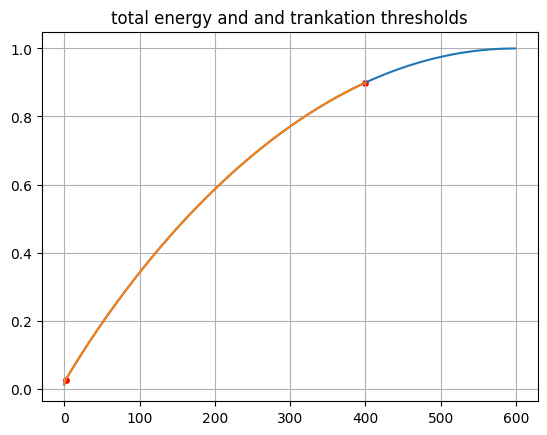

In [49]:
fig, ax = plt.subplots(1,1)
ax.plot(en)
ax.plot(en[:r2+1])
ax.scatter([r], [en[r]], s = 15, c = 'r')
ax.scatter([r2], [en[r2]], s = 15,  c = 'r')
ax.set_title('total energy and and trankation thresholds')


data for SVD should be well aligned. for example pictures of faces should be cropped so different features have same relative position

in this example we generate a rank 2 matrix (2 independent columns)

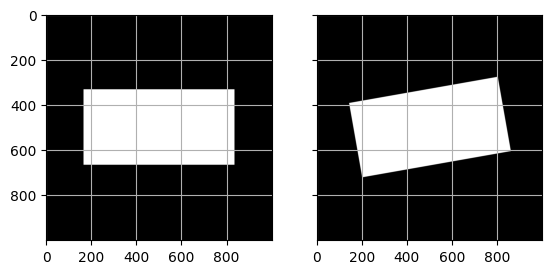

In [50]:
n = 1000

forth = n//3
sixt = n//6

# OG way
X = np.zeros((n,n))
X[forth:-forth,forth:-forth] = 1

# using outer product of eigen vectors 
rowX = np.zeros(n)
rowX[forth:-forth] = 1
colY = np.zeros(n)
colY[sixt:-sixt] = 1

X = np.outer(rowX,colY)

M_rot_img = cv2.getRotationMatrix2D((n//2, n//2), 10, 1.0)
X_rot = cv2.warpAffine(X, M_rot_img, X.shape)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].imshow(X      , cmap='gray')
ax[1].imshow(X_rot  , cmap='gray')

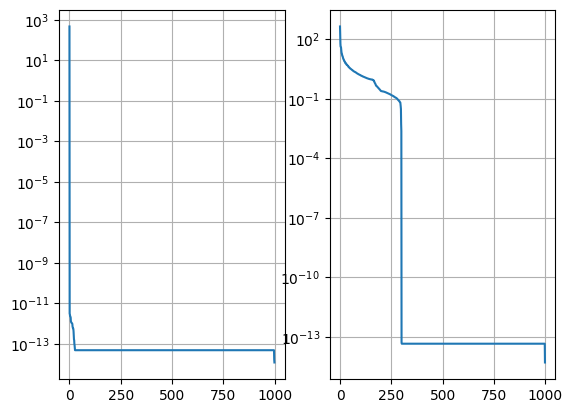

In [51]:
U,S,V       = np.linalg.svd(X       , full_matrices=True)
U2,S2,V2    = np.linalg.svd(X_rot   , full_matrices=True)
fig, ax = plt.subplots(1,2, sharex=True, sharey=False)
ax[0].semilogy(S)
ax[1].semilogy(S2)

In [52]:
def rsvd(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.normal(size=(ny, r+p))
    Z = X @ P
    for _ in np.arange(1,q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z, 'reduced')
    
    # Step 2: Compute SVD on projected Y=Q.T*X
    Y = Q.T @ X
    UY,S,V       = np.linalg.svd(Y, full_matrices=False)
    U = Q @ UY
    return U, S, V

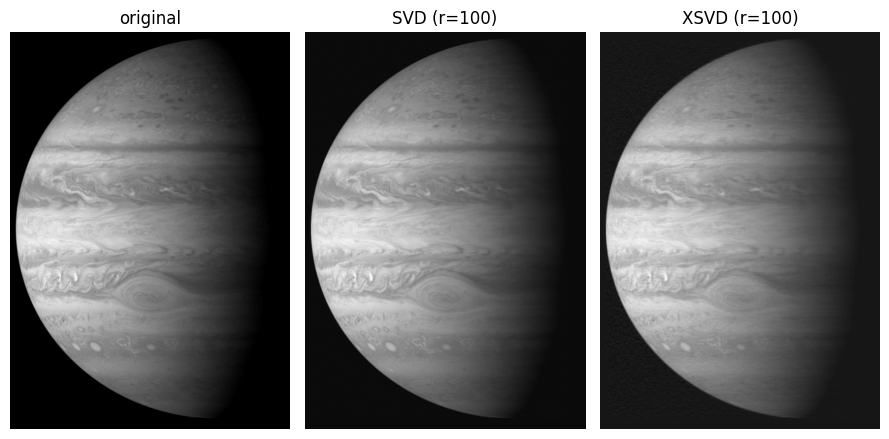

In [53]:
plt.rcParams['axes.grid'] = False
A       = cv2.imread(os.path.join('data_processing','media','jupiter.png'),0)
X       = np.array(A, float)
U,S,V   = np.linalg.svd(X, full_matrices=False)

r = 100 # Target rank
q = 1   # Power iterations
p = 5   # Oversampling parameter

rU, rS, rV = rsvd(X,r,q,p)

XSVD = U[:,:r] @ np.diag(S[:r]) @ V[:r,:]
#errSVD = np.linalg.norm(X - XSVD, axis = 1)/np.linalg.norm(X, axis = 1)
XrSVD = rU[:,:r] @ np.diag(rS[:r]) @ rV[:r,:]

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(9, 6),tight_layout=True)
titles = ['original',f'SVD (r={r})',f'XSVD (r={r})']
for k, img in enumerate([X,XSVD, XrSVD]):
    ax[k].imshow(img, cmap='gray')
    ax[k].axis('off')
    ax[k].set_title(titles[k])